In [23]:
# using Pkg
# Pkg.add("Bits")
# Pkg.add("Plots")
# Pkg.add("LaTeXStrings")

In [3]:
using PauliPropagation
using Plots
using Random
using LaTeXStrings

The code below plot the spectrum of Pauli decomposition, that is, $f(i,\alpha) = i^{(1 + \alpha)}c_i^2$. The default value is $\alpha = -1$

In [4]:
function Plot_Pauli_spectrum!(pic, circuit, observable, parameters; label="Data",alpha = -1)
    #开始Pauli反向传播
    pauli_sum = propagate(circuit, observable, parameters)
    # print(pauli_sum)
    #提取最终Pauli项的系数值
    my_values = [x^2 for x in collect(values(pauli_sum.terms))]
    my_length = length(my_values)
    println("sum_of_c_square=", sum(my_values)) #校验是否归一
    # println("my_length=", my_length)
    sorted_my_values = sort(my_values, rev=true)
    A_values = [(i^(1 + alpha)) * sorted_my_values[i] for i in 1:my_length]
    # print(A_values)
    range = 1:my_length
    plot!(pic, range, A_values, label=label, ylim=(0, 0.007))
end

Plot_Pauli_spectrum! (generic function with 1 method)

Now we try to test the correctness of Noise function in PAULIPROPAGATION.jl package, using circuit with a layer of uniform T gates.

In [26]:
function one_layer_of_T_gate(nqubits::Integer;noise_rate::Real,noise_type::Integer)
    circuit::Vector{Gate} = []
    append!(circuit,(FrozenGate(PauliRotation(:Z, i),pi/4) for i in 1:nqubits))
    if noise_type == 1
        append!(circuit, (FrozenGate(DepolarizingNoise(qind), noise_rate)  for qind in 1:nqubits))
    elseif noise_type == 2
        append!(circuit, (FrozenGate(DephasingNoise(qind), noise_rate)  for qind in 1:nqubits))
    elseif noise_type == 3
        append!(circuit, (FrozenGate(AmplitudeDampingNoise(qind), noise_rate)  for qind in 1:nqubits))
    end
    return circuit
end

one_layer_of_T_gate (generic function with 1 method)

Now we plot the Pauli spectrum for T layers + Depolarization/Dephasing/Amplitude damping noise.

In the case of 8 qubits,

for Depolarization noise, $\sum_{i} c_i^2= =[(1 - p)^{8}]^2 =  0.18530201888518405$

for Dephasing noise, X,Y Pauli has suppression $(1-p)$ and $\sum_{i} c_i^2= =[(1 - p)^{8}]^2 =  0.18530201888518405$

for Aplitude damping noise, X,Y Pauli has suppression $\sqrt{1-p}$ and $\sum_{i} c_i^2= =[(1 - p)^{4}]^2 =  0.4304672099999998$

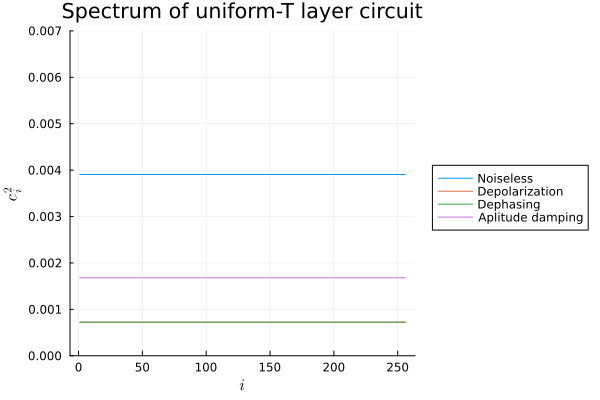

sum_of_c_square=1.0
sum_of_c_square=0.18530201888518405
sum_of_c_square=0.18530201888518405
sum_of_c_square=0.4304672099999998


In [27]:
global nqubits =8
pic = plot(title="Spectrum of uniform-T layer circuit", xlabel=L"i", ylabel=L"c_i^2",legend=:outerright)
circuit = one_layer_of_T_gate(nqubits;noise_rate=0,noise_type=1)
circuit_depolarized = one_layer_of_T_gate(nqubits;noise_rate=0.1,noise_type=1)
circuit_dephasing = one_layer_of_T_gate(nqubits;noise_rate=0.1,noise_type=2)
circuit_AD = one_layer_of_T_gate(nqubits;noise_rate=0.1,noise_type=3)
parameters =[]
observable = PauliSum(nqubits)
add!(observable, [:X for i in 1:nqubits], [i for i in 1: nqubits], 1.0)
Plot_Pauli_spectrum!(pic, circuit, observable, parameters; label="Noiseless")
Plot_Pauli_spectrum!(pic, circuit_depolarized, observable, parameters; label="Depolarization")
Plot_Pauli_spectrum!(pic, circuit_dephasing, observable, parameters; label="Dephasing")
Plot_Pauli_spectrum!(pic, circuit_AD, observable, parameters; label="Aplitude damping")
display(pic)

Now we begin to plot the complexity phase transition point

The code below plot the transition point of function $C(\alpha) :=\max_{i = 1,\cdots,M} i^{\alpha + 1}c_i^2$, where $c_i^2$ is the square of Pauli decomposition coefficient $O = \sum_{i = 1}^M c_i P_i$

In [7]:
function Plot_transition_point!(pic, circuit, observable, parameters; label="Data",range = -1:0.01:0.2)
    #开始Pauli反向传播
    pauli_sum = propagate(circuit, observable, parameters)
    # print(pauli_sum)
    #提取最终Pauli项的系数值
    my_values = [x^2 for x in collect(values(pauli_sum.terms))]
    my_length = length(my_values)
    # println("sum_of_values=", sum(my_values)) #校验是否归一
    # println("my_length=", my_length)
    sorted_my_values = sort(my_values, rev=true)
    # range = -1:0.01:0.2
    Alist = []
    for r in range
        local A_values = [(i^(1 + r))*sorted_my_values[i] for i in 1:my_length]
        sorted_A_values = sort(A_values, rev=true) # 从大到小排序
        A = sorted_A_values[1] #取最大值
        push!(Alist, A)
    end
    # 绘制 A vs r 的图形
    plot!(pic, range, Alist, label=label)
end

Plot_transition_point! (generic function with 1 method)

The function below create a circuit with layer of $SU(4)$ gates and layer of noise channel.

In [29]:
function noisy_su4circuit(nqubits::Integer, nlayers::Integer; topology=nothing,noise_rate=0,noise_type=1)
    
    """
    noisy_su4circuit(nqubits::Integer, nlayers::Integer; topology=nothing)
    Create a circuit that consists of layers of SU(4) gates on a given topology and depolarizing noise layers on each qubit. 
    If no topology is specified, a bricklayer topology is used.
    
    """
        circuit::Vector{Gate} = []
        if isnothing(topology)
            topology = bricklayertopology(nqubits)
        end
        if noise_type == 1
            append!(circuit, (FrozenGate(DepolarizingNoise(qind), noise_rate) for qind in 1:nqubits))
            for nl in 1:nlayers
                for pair in topology
                    appendSU4!(circuit, pair)
                end
                append!(circuit, (FrozenGate(DepolarizingNoise(qind), noise_rate)  for qind in 1:nqubits))
            end
        elseif noise_type == 2
            append!(circuit, (FrozenGate(DephasingNoise(qind), noise_rate) for qind in 1:nqubits))
            for nl in 1:nlayers
                for pair in topology
                    appendSU4!(circuit, pair)
                end
            end
                append!(circuit, (FrozenGate(DephasingNoise(qind), noise_rate)  for qind in 1:nqubits))
        elseif noise_type == 3
            append!(circuit, (FrozenGate(AmplitudeDampingNoise(qind), noise_rate) for qind in 1:nqubits))
            for nl in 1:nlayers
                for pair in topology
                    appendSU4!(circuit, pair)
                end
                append!(circuit, (FrozenGate(AmplitudeDampingNoise(qind), noise_rate)  for qind in 1:nqubits))
            end
        end
    
        return circuit
    end

noisy_su4circuit (generic function with 1 method)

Now we plot the phase transition diagram for three type of noise.

The circuit is chosen with 10 layers of su4 + noise

The qubit number is chosen as 8

The Pauli operator in the end of circuit(thus being the operator before propagation) is $X^{\otimes n}$ 

In [30]:
global nqubits = 8
global topology = bricklayertopology(nqubits; periodic=true)
global nlayers = 10
prototype_circuit = noisy_su4circuit(nqubits, nlayers;topology=topology)
nparams = countparameters(prototype_circuit)
Random.seed!(1234)
global rand_para = rand(nparams)
#确定最终要测量的Pauli算符
global observable2 = PauliSum(nqubits)
add!(observable2, [:X for i in 1:nqubits], [i for i in 1: nqubits], 1.0)

PauliSum(nqubits: 8, 1 Pauli term: 
 1.0 * XXXXXXXX
)

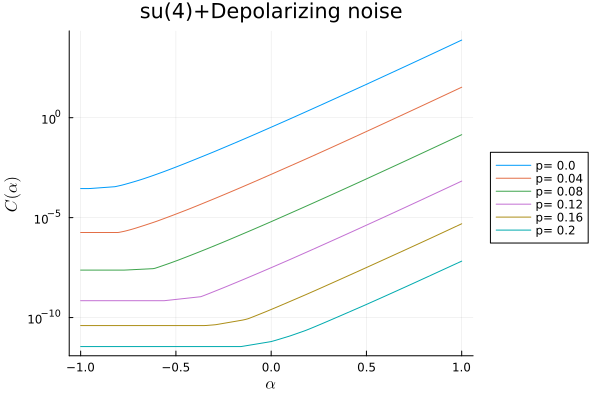

In [31]:
pic1 = plot(title="su(4)+Depolarizing noise", xlabel=L"\alpha", ylabel=L"C(\alpha)", yscale=:log10,legend=:outerright)
for noise_rate in 0:0.04:0.2
    local circuit2 = noisy_su4circuit(nqubits, nlayers; topology=topology,noise_rate = noise_rate,noise_type = 1)
    local parameters2 = rand_para * pi
    # # Plot the second dataset
    Plot_transition_point!(pic1, circuit2, observable2, parameters2; label="p= $noise_rate",range=-1:0.01:1)
end
display(pic1)

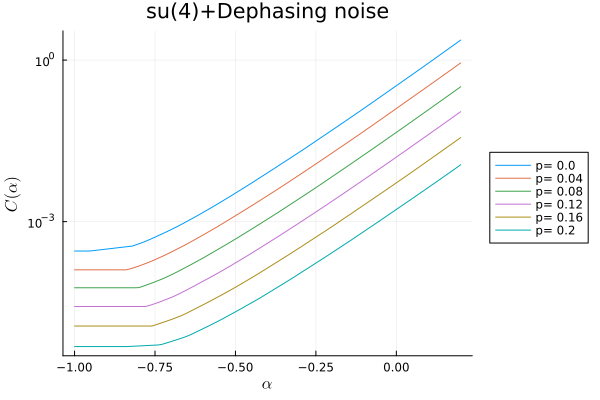

In [32]:
pic2 = plot(title="su(4)+Dephasing noise", xlabel=L"\alpha", ylabel=L"C(\alpha)", yscale=:log10,legend=:outerright)
for noise_rate in 0:0.04:0.2
    local circuit2 = noisy_su4circuit(nqubits, nlayers; topology=topology,noise_rate = noise_rate,noise_type = 2)
    local parameters2 = rand_para * pi
    # # Plot the second dataset
    Plot_transition_point!(pic2, circuit2, observable2, parameters2; label="p= $noise_rate")
end
display(pic2)

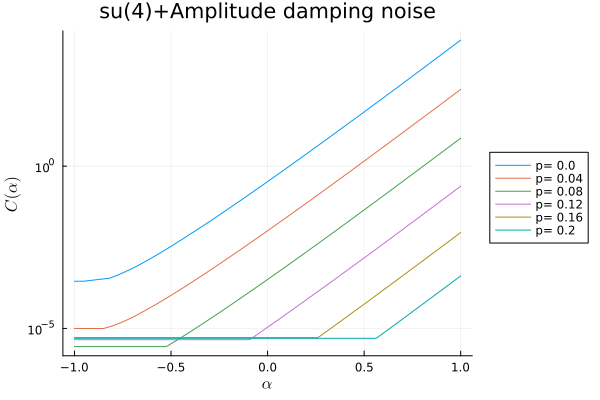

In [33]:
pic3 = plot(title="su(4)+Amplitude damping noise", xlabel=L"\alpha", ylabel=L"C(\alpha)", yscale=:log10,legend=:outerright)
for noise_rate in 0:0.04:0.2
    local circuit2 = noisy_su4circuit(nqubits, nlayers; topology=topology,noise_rate = noise_rate,noise_type = 3)
    local parameters2 = rand_para * pi
    # # Plot the second dataset
    Plot_transition_point!(pic3, circuit2, observable2, parameters2; label="p= $noise_rate",range=-1:0.01:1)
end
display(pic3)

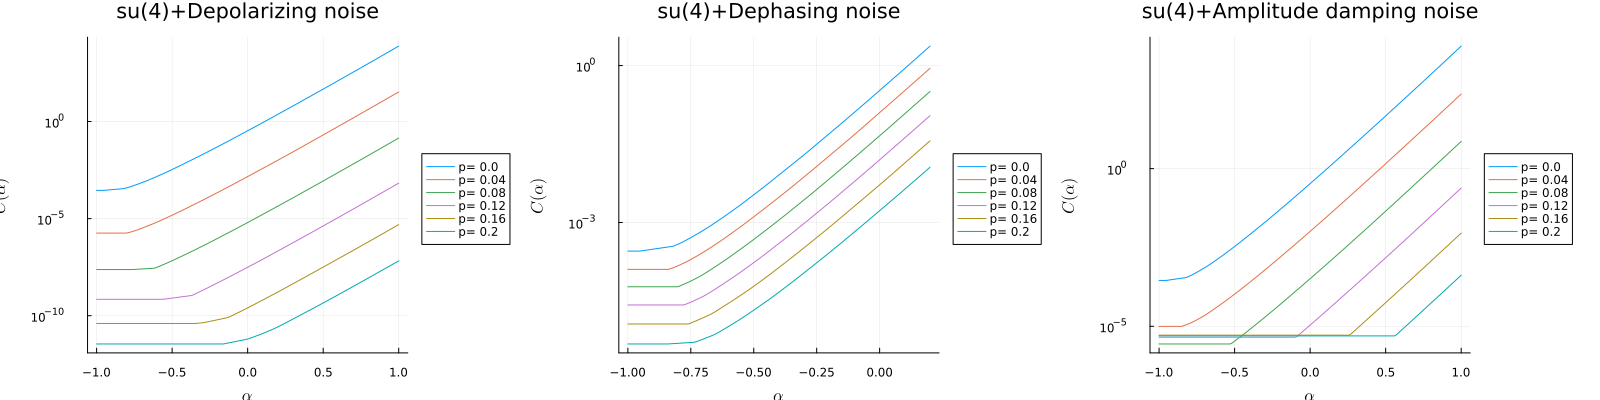

In [42]:
# Combine the plots side by side
combined_plot = plot(pic1, pic2, pic3, layout=(1, 3),size=(1600, 400),margin=5Plots.mm)
# Save the combined plot as a PNG file
savefig(combined_plot, "combined_plot.png")
# Display the combined plot
display(combined_plot)

Similarly, we plot the phase transition diagram for three type of noise in 10 layers of \{Clifford + T + noise\} circuit

The qubit number is chosen as 8

The Pauli operator in the end of circuit(thus being the operator before propagation) is $X^{\otimes n}$ 

In [43]:
function noisy_Clifford_T_circuit(nqubits::Integer, nlayers::Integer; topology=nothing,noise_rate::Real,noise_type::Integer,random_select)
    circuit::Vector{Gate} = []
    if isnothing(topology)
        topology = bricklayertopology(nqubits)
    end
    ### first layer of noise
    if noise_type == 1
        append!(circuit, (FrozenGate(DepolarizingNoise(qind), noise_rate)  for qind in 1:nqubits))
    elseif noise_type == 2
        append!(circuit, (FrozenGate(DephasingNoise(qind), noise_rate)  for qind in 1:nqubits))
    elseif noise_type == 3 
        append!(circuit, (FrozenGate(AmplitudeDampingNoise(qind), noise_rate)  for qind in 1:nqubits))
    end
    ###layer of Clifford
    count = 1
    for nl in 1:nlayers
        for pair in topology
            if random_select[count]
                push!(circuit, CliffordGate(:CNOT, pair))
            end
            count = count + 1
        end
        for indx in 1:nqubits
            if random_select[count]
                push!(circuit, CliffordGate(:H, indx))
            end
            count = count + 1
            if random_select[count]
                push!(circuit, CliffordGate(:S, indx))
            end
            count = count + 1
        end
        #T layers
        for indx in 1:nqubits
            if random_select[count]
                push!(circuit, FrozenGate(PauliRotation(:Z, indx),pi/4))
            end
            count = count + 1
        end
        #Noise layer
        if noise_type == 1
            append!(circuit, (FrozenGate(DepolarizingNoise(qind), noise_rate)  for qind in 1:nqubits))
        elseif noise_type == 2
            append!(circuit, (FrozenGate(DephasingNoise(qind), noise_rate)  for qind in 1:nqubits))
        elseif noise_type == 3 
            append!(circuit, (FrozenGate(AmplitudeDampingNoise(qind), noise_rate)  for qind in 1:nqubits))
        end
    end
    return circuit
end

noisy_Clifford_T_circuit (generic function with 1 method)

In [44]:
global nqubits = 8
global topology = bricklayertopology(nqubits; periodic=true)
global nlayers = 10
N = nlayers * (length(bricklayertopology(nqubits)) + 4*nqubits)
Random.seed!(1234)
global random_select =rand(Bool, N)
#确定最终要测量的Pauli算符
global observable2 = PauliSum(nqubits)
add!(observable2, [:X for i in 1:nqubits], [i for i in 1: nqubits], 1.0)

PauliSum(nqubits: 8, 1 Pauli term: 
 1.0 * XXXXXXXX
)

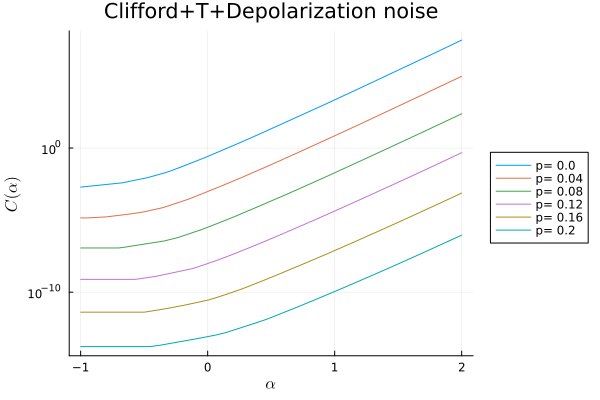

In [45]:
pic4 = plot(title="Clifford+T+Depolarization noise", xlabel=L"\alpha", ylabel=L"C(\alpha)", yscale=:log10,legend=:outerright)
for noise_rate in 0:0.04:0.2
    local circuit2 = noisy_Clifford_T_circuit(nqubits, nlayers; topology=topology,noise_rate = noise_rate,noise_type = 1,random_select=random_select)
    local parameters2 = []
    # # Plot the second dataset
    Plot_transition_point!(pic4, circuit2, observable2, parameters2; label="p= $noise_rate",range = -1:0.01:2)
end
display(pic4)

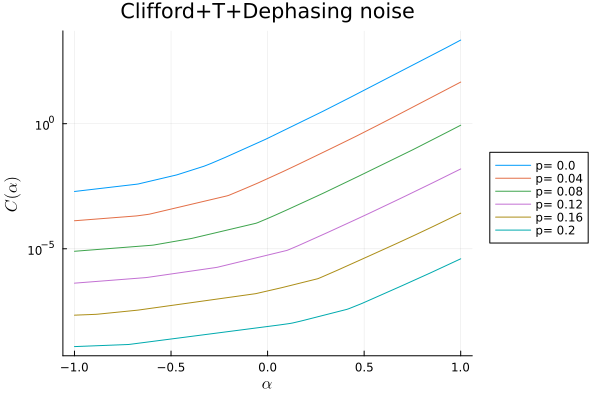

In [46]:
pic5 = plot(title="Clifford+T+Dephasing noise", xlabel=L"\alpha", ylabel=L"C(\alpha)", yscale=:log10,legend=:outerright)
for noise_rate in 0:0.04:0.2
    local circuit2 = noisy_Clifford_T_circuit(nqubits, nlayers; topology=topology,noise_rate = noise_rate,noise_type = 2,random_select=random_select)
    local parameters2 = []
    # # Plot the second dataset
    Plot_transition_point!(pic5, circuit2, observable2, parameters2; label="p= $noise_rate",range = -1:0.01:1)
end
display(pic5)

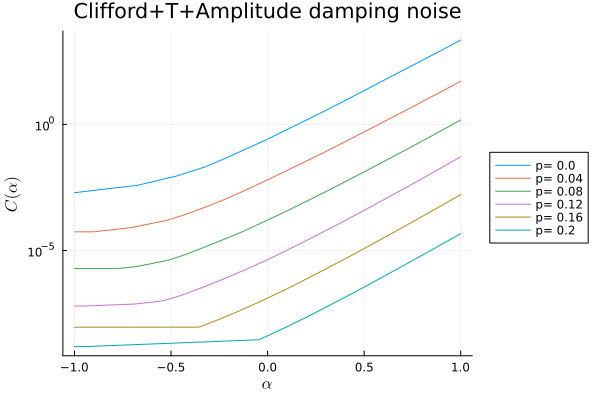

In [47]:
pic6 = plot(title="Clifford+T+Amplitude damping noise", xlabel=L"\alpha", ylabel=L"C(\alpha)", yscale=:log10,legend=:outerright)
for noise_rate in 0:0.04:0.2
    local circuit2 = noisy_Clifford_T_circuit(nqubits, nlayers; topology=topology,noise_rate = noise_rate,noise_type = 3,random_select=random_select)
    local parameters2 = []
    # # Plot the second dataset
    Plot_transition_point!(pic6, circuit2, observable2, parameters2; label="p= $noise_rate",range = -1:0.01:1)
end
display(pic6)

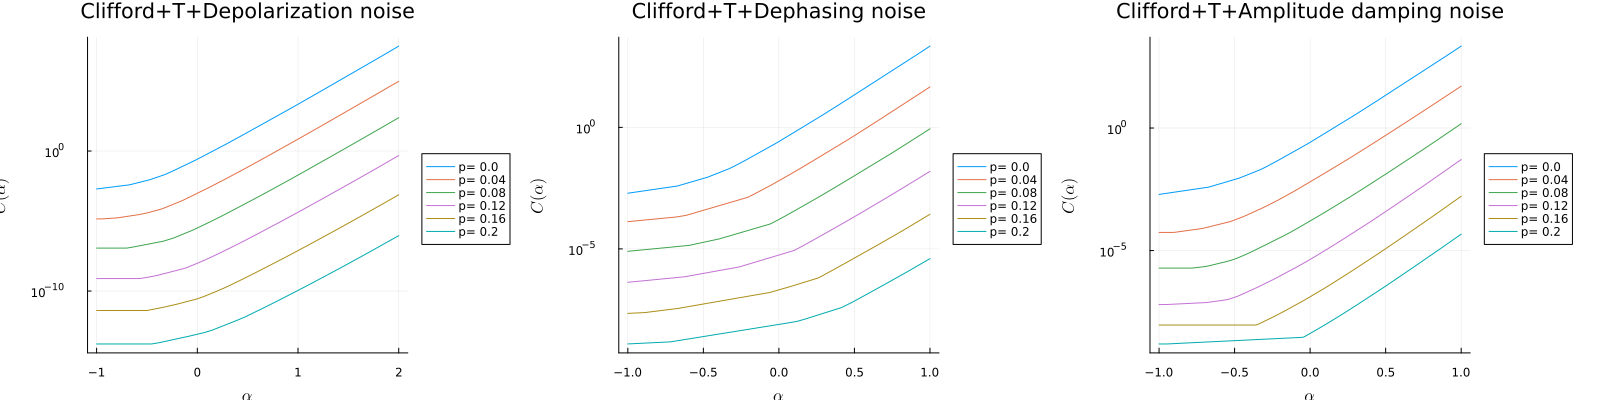

In [49]:
# Combine the plots side by side
combined_plot2 = plot(pic4, pic5, pic6, layout=(1, 3),size=(1600, 400),margin=5Plots.mm)
# Save the combined plot as a PNG file
savefig(combined_plot2, "combined_plot2.png")
# Display the combined plot
display(combined_plot2)

In [10]:
function new_noisy_Clifford_T_circuit(nqubits::Integer, nlayers::Integer;noise_rate::Real,noise_type::Integer,random_select)
    circuit::Vector{Gate} = []
    ### first layer of noise
    if noise_type == 1
        append!(circuit, (FrozenGate(DepolarizingNoise(qind), noise_rate)  for qind in 1:nqubits))
    elseif noise_type == 2
        append!(circuit, (FrozenGate(DephasingNoise(qind), noise_rate)  for qind in 1:nqubits))
    elseif noise_type == 3 
        append!(circuit, (FrozenGate(AmplitudeDampingNoise(qind), noise_rate)  for qind in 1:nqubits))
    end
    ###layer of Clifford
    count = 1
    for nl in 1:nlayers
        for qubit_ind in 1:nqubits
            choise = random_select[count]
            if choise == 1
                push!(circuit, CliffordGate(:H, qubit_ind))
            elseif choise == 2
                push!(circuit, CliffordGate(:S, qubit_ind))
            elseif choise == 3
                push!(circuit, FrozenGate(PauliRotation(:Z, qubit_ind),pi/4))
            elseif choise == 4
                push!(circuit, CliffordGate(:CNOT, (qubit_ind, (qubit_ind+1)%nqubits)))
            end
            count = count + 1
        end
        #Noise layer
        if noise_type == 1
            append!(circuit, (FrozenGate(DepolarizingNoise(qind), noise_rate)  for qind in 1:nqubits))
        elseif noise_type == 2
            append!(circuit, (FrozenGate(DephasingNoise(qind), noise_rate)  for qind in 1:nqubits))
        elseif noise_type == 3 
            append!(circuit, (FrozenGate(AmplitudeDampingNoise(qind), noise_rate)  for qind in 1:nqubits))
        end
    end
    return circuit
end

new_noisy_Clifford_T_circuit (generic function with 1 method)

In [1]:
global nqubits = 8
global nlayers = 40
Random.seed!(1234)
global random_select =rand([1, 2, 3, 4], nqubits*nlayers)
#确定最终要测量的Pauli算符
global observable2 = PauliSum(nqubits)
add!(observable2, [:X for i in 1:nqubits], [i for i in 1: nqubits], 1.0)

pic7 = plot(title="Clifford+T+Depolarization noise", xlabel=L"\alpha", ylabel=L"C(\alpha)", yscale=:log10,legend=:outerright)
for noise_rate in 0:0.02:0.1
    local circuit2 = new_noisy_Clifford_T_circuit(nqubits, nlayers;noise_rate = noise_rate,noise_type = 1,random_select=random_select)
    local parameters2 = []
    # # Plot the second dataset
    Plot_transition_point!(pic7, circuit2, observable2, parameters2; label="p= $noise_rate",range = -1:0.001:1)
end

pic8 = plot(title="Clifford+T+Dephasing noise", xlabel=L"\alpha", ylabel=L"C(\alpha)", yscale=:log10,legend=:outerright)
for noise_rate in 0:0.02:0.1
    local circuit2 = new_noisy_Clifford_T_circuit(nqubits, nlayers;noise_rate = noise_rate,noise_type = 2,random_select=random_select)
    local parameters2 = []
    # # Plot the second dataset
    Plot_transition_point!(pic8, circuit2, observable2, parameters2; label="p= $noise_rate",range = -1:0.001:1)
end

pic9 = plot(title="Clifford+T+Amplitude damping noise", xlabel=L"\alpha", ylabel=L"C(\alpha)", yscale=:log10,legend=:outerright)
for noise_rate in 0:0.02:0.1
    local circuit2 = new_noisy_Clifford_T_circuit(nqubits, nlayers;noise_rate = noise_rate,noise_type = 3,random_select=random_select)
    local parameters2 = []
    # # Plot the second dataset
    Plot_transition_point!(pic9, circuit2, observable2, parameters2; label="p= $noise_rate",range = -1:0.001:1)
end

# Combine the plots side by side
combined_plot3 = plot(pic7, pic8, pic9, layout=(1, 3),size=(1600, 400),margin=5Plots.mm)
# Save the combined plot as a PNG file
savefig(combined_plot3, "combined_plot3.png")
# Display the combined plot
display(combined_plot3)

UndefVarError: UndefVarError: `Random` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: Random is loaded but not imported in the active module Main.